In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import multiprocessing

from time import time
import warnings
import os
import sys
import gc
import itertools
from collections import Counter
from datetime import datetime
from pathlib import Path
from featexp import get_univariate_plots
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# visualization 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# data preprocessing 
import missingno
from featexp import get_univariate_plots
from featexp import get_trend_stats
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.decomposition import PCA, TruncatedSVD

# model
import xgboost as xgb
import lightgbm as lgb
import catboost as cb 
# ERROR: AttributeError: type object '_catboost._FloatArrayWrapper' has no attribute '__reduce_cython__'
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

# eveluation 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# hyperparameters tuning 
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
seed = 9527

/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Data 

In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target `isFraud`.

The data is broken into two files identity and transaction, which are joined by `TransactionID`. Not all transactions have corresponding identity information.

The data comes from **Vesta's real-world e-commerce** transactions and contains a wide range of features from device type to product features.

### Categorical Features - Transaction
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual * meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

### Categorical Features - Identity
Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. 
They're collected by Vesta’s fraud protection system and digital security partners.
(The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

**Categorical Features:**
* DeviceType
* DeviceInfo
* id12 - id38

In [2]:
main_path = Path('../input/ieee-cis-fraud-detection/')

train_transaction_data = pd.read_csv(main_path / 'train_transaction.csv')
train_identity_data = pd.read_csv(main_path / 'train_identity.csv')
test_transaction_data = pd.read_csv(main_path / 'test_transaction.csv')
test_identity_data = pd.read_csv(main_path / 'test_identity.csv')

print('Number of train transaction data:{}\nNumber of train identity data:{}'.format(
    train_transaction_data.shape[0],
    train_identity_data.shape[0]
))

print('Number of test transaction data:{}\nNumber of test identity data:{}'.format(
    test_transaction_data.shape[0],
    test_identity_data.shape[0]
))

Number of train transaction data:590540
Number of train identity data:144233
Number of test transaction data:506691
Number of test identity data:141907


In [15]:
'''
# Add the path to the feature stats generation code.
import sys
sys.path.insert(0, '/tf/notebooks/facets/facets_overview/python')
# Create the feature stats for the datasets and stringify it.
import base64
from generic_feature_statistics_generator import GenericFeatureStatisticsGenerator
gfsg = GenericFeatureStatisticsGenerator()
proto = gfsg.ProtoFromDataFrames([{'name': 'train', 'table': train_transaction_data},
                                  {'name': 'test', 'table': test_transaction_data}])
protostr = base64.b64encode(proto.SerializeToString()).decode("utf-8")
'''

In [32]:
train_data = pd.merge(train_transaction_data, train_identity_data, on='TransactionID', how='left')
test_data = pd.merge(test_transaction_data, test_identity_data, on='TransactionID', how='left')

In [34]:
train_data.shape, test_data.shape

((590540, 434), (506691, 433))

# EDA

1. Distribution of each features
2. Distribution of target by features
3. How many columns contain Null value?
4. Does data has outliers? 

### Target Distribution

Text(0.5, 0, 'isFraud')

Text(0, 0.5, 'Count')

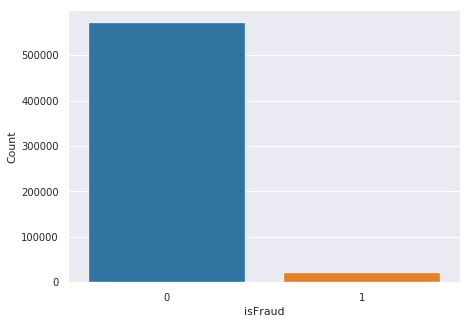

In [3]:
target_count = train_transaction_data['isFraud'].value_counts()
fig, ax = plt.subplots(1, 1, figsize=(7, 5), sharex=True)
sns.barplot(target_count.index, target_count.values, ax=ax)
ax.set_xlabel('isFraud')
ax.set_ylabel('Count')


### Transcation table

In [4]:
target_col = 'isFraud'
base_cols = ['TransactionID', 'TransactionDT', 'TransactionAmt', 'ProductCD']
card_cols = ['card1', 'card2', 'card3', 'card4', 'card5', 'card6']
C_cols = [ 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
D_cols = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']
M_cols = ['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
V_cols = ['V{}'.format(i) for i in range(1, 340)]
other_cols = ['addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain']

In [5]:
print('Unique transcation id:{}'.format(train_transaction_data.TransactionID.nunique()))

Unique transcation id:590540


* ***categories columns***


In [6]:
categories_cols = []
for k, v in train_transaction_data.dtypes.items():
    if v == 'object':
        categories_cols.append(k)

* ***time feature***

In [7]:
time_span = test_transaction_data['TransactionDT'].max() - train_transaction_data['TransactionDT'].min()
print('Time span between train and test: {} year'.format(datetime_period / (365*24*60*60)))

NameError: name 'datetime_period' is not defined

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.distplot(train_transaction_data['TransactionDT'], label='train', kde=False, bins=10, ax=ax)
sns.distplot(test_transaction_data['TransactionDT'], label='test', kde=False, bins=10, ax=ax)
ax.set_title('Distribution of transactiond dates')

Text(0.5, 1.0, 'Train transaction')

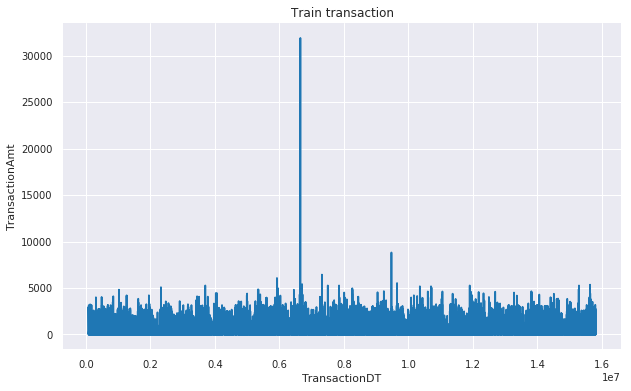

In [9]:
train_grouped_data =  train_transaction_data.groupby('TransactionDT').agg({
    'TransactionAmt': 'sum'
}).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
g = sns.lineplot(x='TransactionDT', y='TransactionAmt', data=train_grouped_data, ax=ax)
g.set_title('Train transaction')



Text(0.5, 1.0, 'Test transaction')

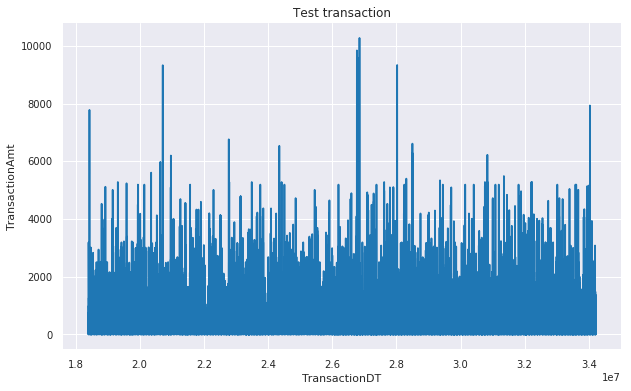

In [10]:
test_grouped_data = test_transaction_data.groupby('TransactionDT').agg({
    'TransactionAmt': 'sum'
}).reset_index()

fig, ax = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
g = sns.lineplot(x='TransactionDT', y='TransactionAmt', data=test_grouped_data, ax=ax)
g.set_title('Test transaction')


                                       Plots for TransactionID                                        


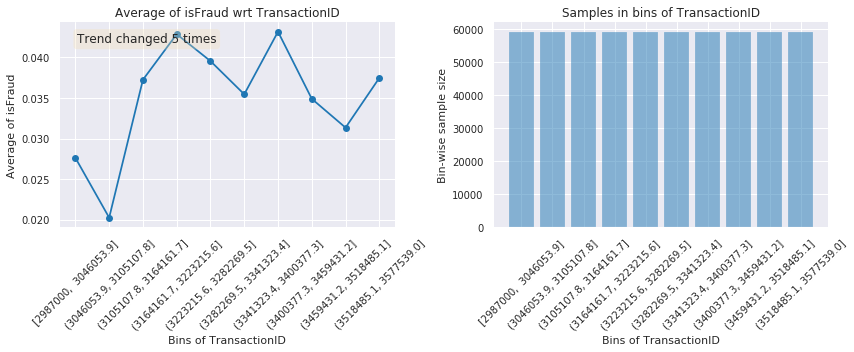

--------------------------------------------------------------------------------------------------------------


                                       Plots for TransactionDT                                        


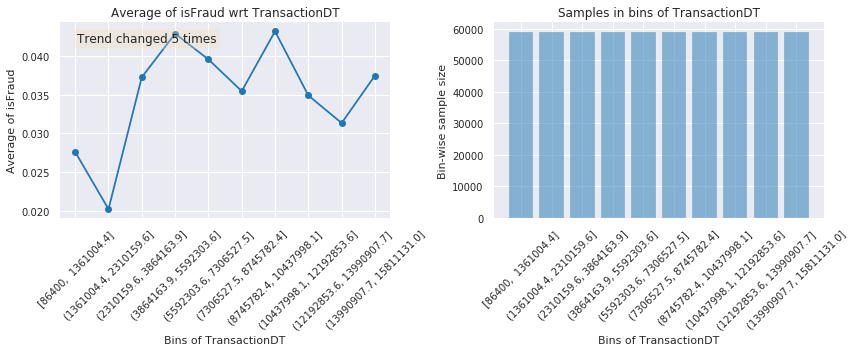

--------------------------------------------------------------------------------------------------------------


                                       Plots for TransactionAmt                                       


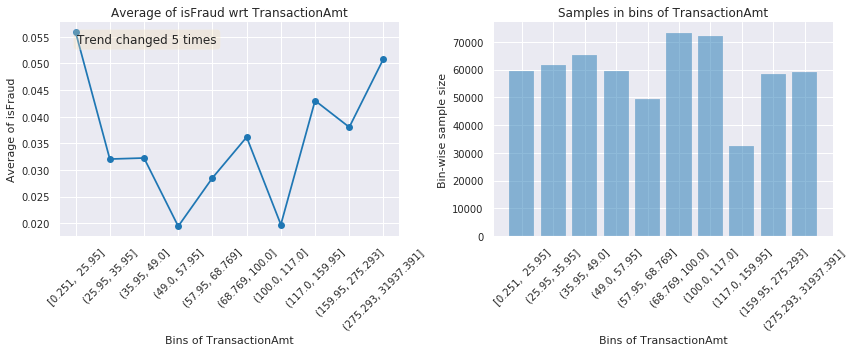

--------------------------------------------------------------------------------------------------------------


ProductCD is categorical. Categorical features not supported yet.


In [126]:
get_univariate_plots(data=train_transaction_data[base_cols + [target_col]], 
                     target_col=target_col, 
                     bins=10,
                     features_list=base_cols)

#stats = get_trend_stats(data=train_df[fe_feature_cols + [target_col]], 
#                        target_col='label', 
#                        data_test=test_df[fe_feature_cols + [target_col]])

In [73]:
def plot_cate_feature_distribtion(data, feature, target):
    tmp = pd.crosstab(data[feature], data[target], normalize='index') * 100
    tmp = tmp.reset_index()
    total = len(data)    
    tmp_count = data[feature].value_counts()
    categories_name = tmp_count.index.tolist()
    
    plt.figure(figsize=(14, 6))
    plt.suptitle('{} Distributions'.format(feature), fontsize=20)
    plt.subplot(121)
    g = sns.countplot(x=feature, data=data, order=categories_name)
    g.set_title('{} Distributions'.format(feature), fontsize=15)
    g.set_xlabel("{} Name".format(feature), fontsize=15)
    g.set_ylabel("Count", fontsize=15)
    g.set_ylim(0, tmp_count[0] + tmp_count[-1])
    for p in g.patches:
        height = p.get_height()
        g.text(p.get_x() + p.get_width()/2, 
               height + 3,
               '{:1.2f}%'.format(height / total*100),
               ha="center", fontsize=14) 
        
    plt.subplot(122)
    g1 = sns.countplot(x=feature, hue=target, data=data, order=categories_name)
    plt.legend(title='{}'.format(target_col), loc='best', labels=data[target_col].unique().tolist())
    gt = g1.twinx()
    gt = sns.pointplot(x=feature, y=data[target_col].unique().tolist()[1], 
                       data=tmp, color='black', order=categories_name, legend=False)
    gt.set_ylabel("% of positive target", fontsize=14)
    g1.set_title("{} by Target({})".format(feature, target_col), fontsize=15)
    g1.set_xlabel("{}".format(feature), fontsize=17)
    g1.set_ylabel("Count", fontsize=17)
    plt.subplots_adjust(hspace = 0.6, top = 0.85)
    plt.show()

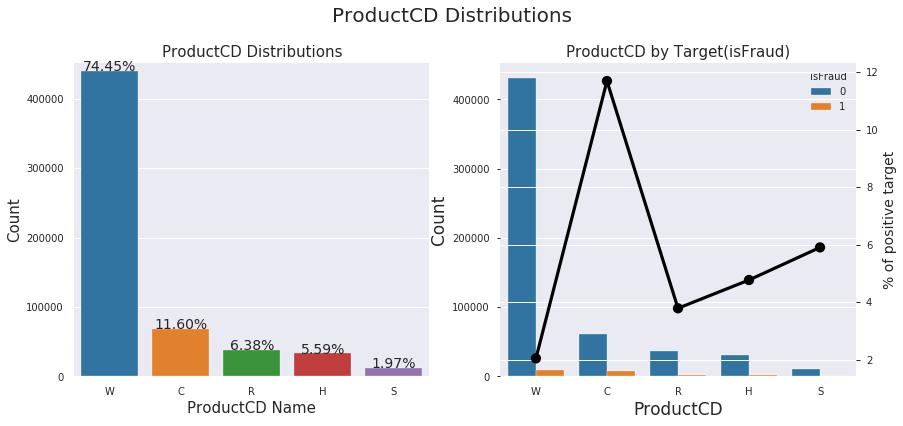

In [74]:
plot_cate_feature_distribtion(train_transaction_data, 'ProductCD', target_col)

In [83]:
def plot_interaction_w_target(data, feature1, feature2, target):
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    sns.boxenplot(x=feature1, y=feature2, hue=target, data=data, ax=ax)
    ax.set_title("{} by {} and {}".format(feature1, feature2, target), fontsize=16)
    ax.set_xlabel("{}".format(feature1), fontsize=17)
    ax.set_ylabel("{}".format(feature2), fontsize=17)


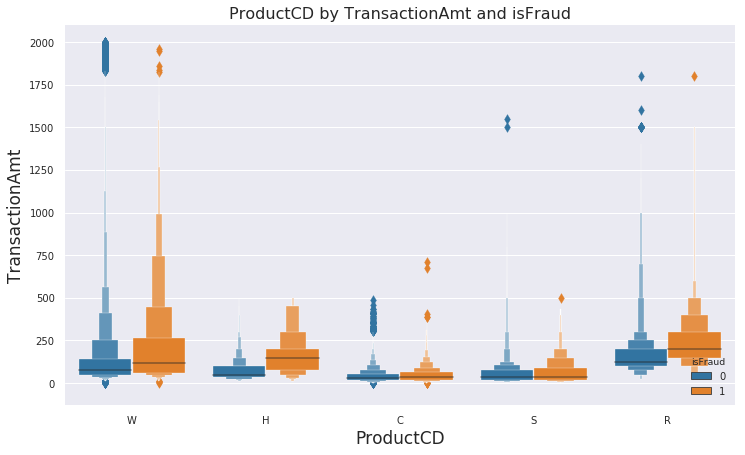

In [84]:
plot_interaction_w_target(train_transaction_data[train_transaction_data['TransactionAmt'] <= 2000], 
                          'ProductCD', 'TransactionAmt', 'isFraud')


In [10]:
train_identity_data.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
print('Unique transcation id at identity table:{}'.format(train_identity_data.TransactionID.nunique()))
print('Unique transcation id at identity table:{}'.format(train_transaction_data.TransactionID.nunique()))

Train data and test data have different datetime with data point, so it could use time split method to do cross validation.

# Data wrangling and Data Clean

### Remove outlier or not

### Handle missing value

# Baseline model

# Feature engineering 

# Cross validation

# HPO

# Ensembling